# Marketing Campaign Analysis
## Event study using time series

### Period May 2018 - April 2019
 

# Overview of Analysis
## 1 . Utilise Opens and Enrollments
## 2. Model the past up to February; generates existing run rate
## 3. Forecast March and April using existing run rate
## 4. Compare to actual change after the default setting changed


# Key Findings
## - Despite limited data able to make reasonable models of Email Opens and Joiners
### - Error rate of fit is 16 - 17%
## - Using the model, we projected out the March and April values as if no pilot marketing campaign happened
## - For both series, the pilot campaign changed then  March and April counts

In [1]:
import pandas as pd
from pandas.plotting import lag_plot


import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff

from statsmodels.tools.eval_measures import rmse

%matplotlib inline

In [2]:
# get the Dickey-Fuller function


from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [3]:
# ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
os.getcwd()


'/Users/Bryan/Documents/Programming/useR'

In [5]:
# load the data create the index for dates

df = pd.read_csv('Subscriptions.csv', index_col='Date', parse_dates=True)
df.index = pd.to_datetime(df.index, dayfirst=True)

# set up for monthly
df.index.freq = 'MS'

df.head()

,Joiners,Opens,Potential,Email
Date,,,,
2018-05-01,358,45,198,1425
2018-06-01,255,455,1761,1096
2018-07-01,206,588,2318,900
2018-08-01,177,654,2769,843
2018-09-01,113,514,2477,723


# Plot of all Series Data

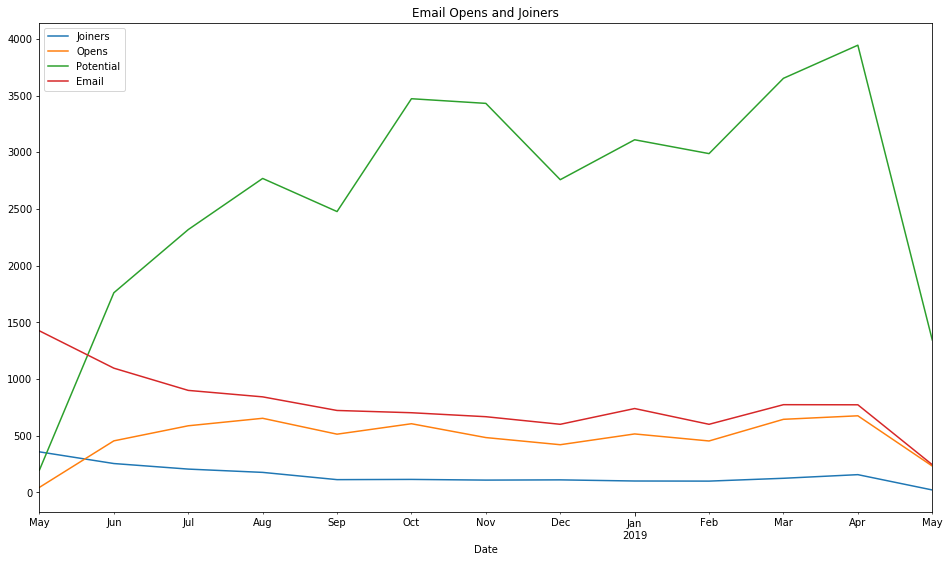

In [6]:
# view all of the series

df.plot(figsize=(16,9), legend=True, title='Email Opens and Joiners')

In [7]:
# check the length of the file

len(df)

13

In [8]:
# adf test
adf_test(df['Opens'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -2.052673
p-value                 0.263966
# lags used             3.000000
# observations          9.000000
critical value (1%)    -4.473135
critical value (5%)    -3.289881
critical value (10%)   -2.772382
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [9]:
dfRed = df.iloc[1:12].copy()

# Reduced Series (drop first Data Point)

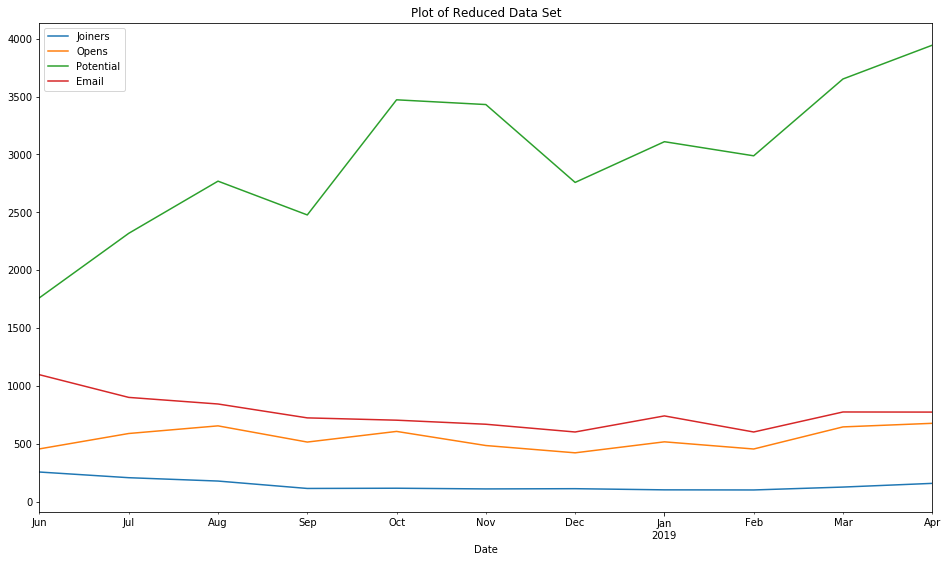

In [10]:
dfRed.plot(figsize=(16,9), legend=True, title='Plot of Reduced Data Set')

In [11]:
# separate the IL data
data = df[['Opens', 'Joiners']]

# remove the ends
data_red = data.iloc[1:12]

data_red.head()

,Opens,Joiners
Date,,
2018-06-01,455,255
2018-07-01,588,206
2018-08-01,654,177
2018-09-01,514,113
2018-10-01,606,115


# Series that are Being Modeled
## Opens and Joiners (New Customers)

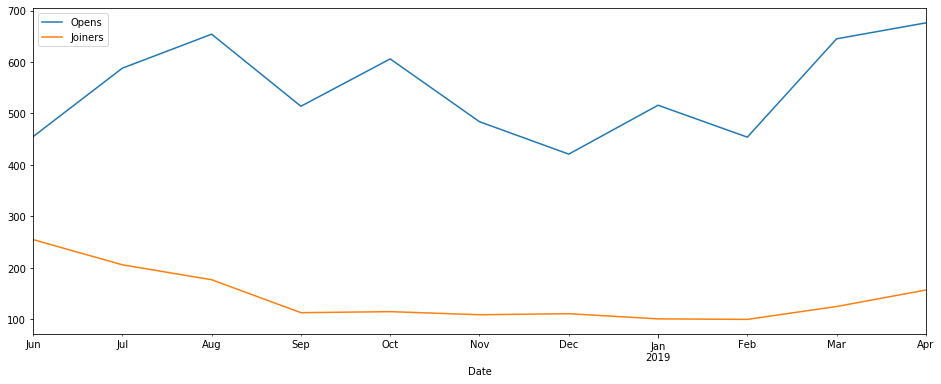

In [12]:
data_red.plot(figsize=(16,6), legend=True)

# Determine the Structure of the Data
## The next series of plots are statistical tests on the structure of the data that allow for the determination of models.

In [ ]:
# adf test
adf_test(data_red['Opens'])

In [ ]:
# adf test
adf_test(data_red['Joiners'])

# Open Correllations

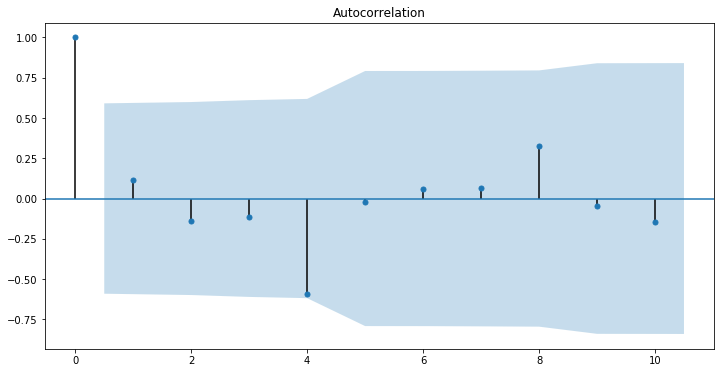

In [13]:
# check the ACF of opens

N, M = 12, 6
fig, ax = plt.subplots(figsize=(N, M))
plot_acf(data_red['Opens'], lags=10, ax=ax)
plt.show()

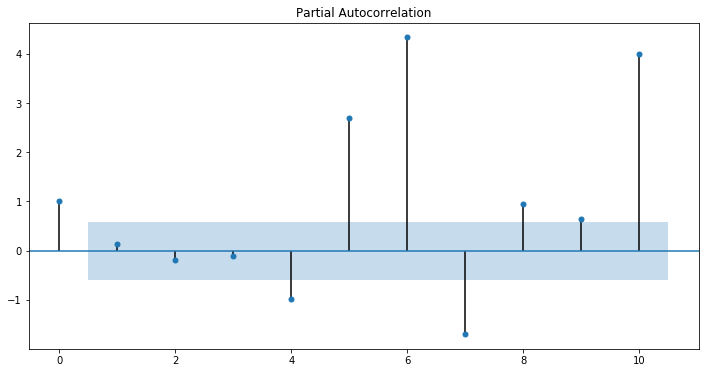

In [14]:
# check PACF of opens

N, M = 12, 6
fig, ax = plt.subplots(figsize=(N, M))
plot_pacf(data_red['Opens'], lags=10, ax=ax)
plt.show()

# Enrollment Correlations

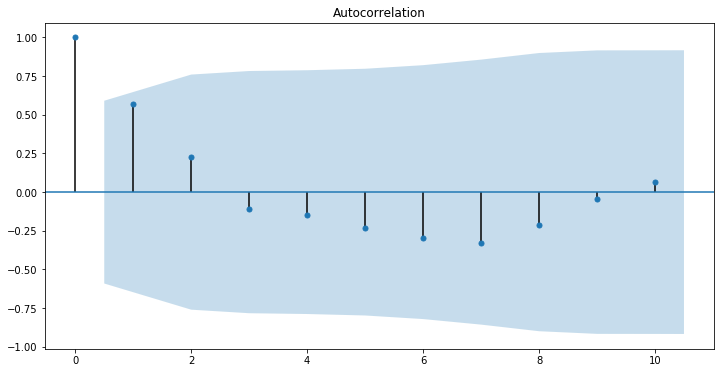

In [15]:
# check the ACF of Joiners

N, M = 12, 6
fig, ax = plt.subplots(figsize=(N, M))
plot_acf(data_red['Joiners'], lags=10, ax=ax)
plt.show()

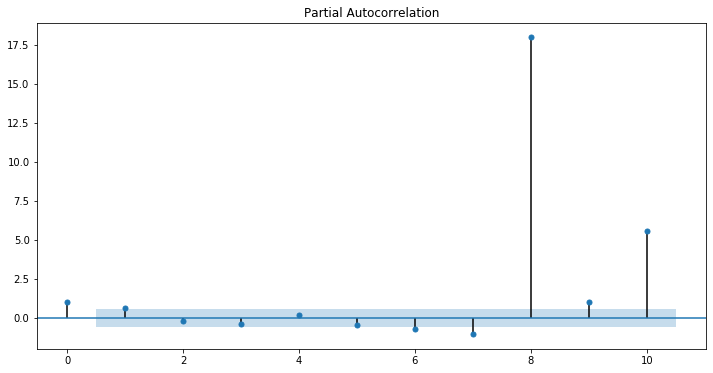

In [16]:
# check the PACF of Joiners

N, M = 12, 6
fig, ax = plt.subplots(figsize=(N, M))
plot_pacf(data_red['Joiners'], lags=10, ax=ax)
plt.show()

# Build Model of Opens

In [17]:
# split pre-reg

train = data_red['Opens'].iloc[0:9]
test = data_red['Opens'].iloc[9:]

In [18]:
# select 0,1,1 for order

model = ARIMA(train, order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Opens   No. Observations:                    8
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -46.632
Method:                       css-mle   S.D. of innovations             71.726
Date:                Wed, 04 Sep 2019   AIC                             99.264
Time:                        15:09:14   BIC                             99.502
Sample:                    07-01-2018   HQIC                            97.656
                         - 02-01-2019                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -11.9333      9.259     -1.289      0.245     -30.080       6.213
ma.L1.D.Opens    -0.9997      0.384     -2.604      0.040      -1.752      -0.247
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0003           +0.0000j            1.0003            0.0000
-----------------------------------------------------------------------------
"""

In [19]:
start = len(train)
end = len(train) + len(test) - 1

predictions = results.predict(start=start, end=end, typ='levels').rename('Modeled Run_Rate')

# Compare Model to Existing Series
## - Model has reasonable fit give the small amount of data
## - Actual error in the model is 17%

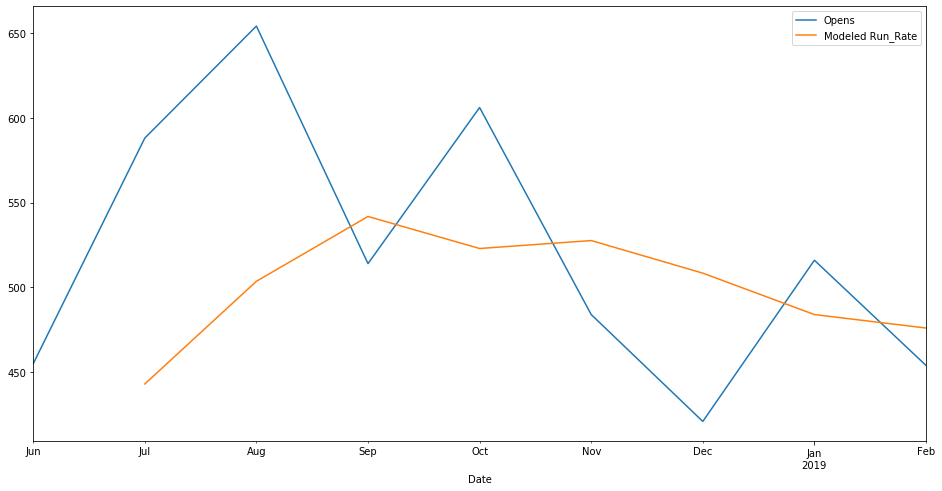

In [20]:
backtest = results.predict(start=1, end=start-1, typ='levels').rename('Modeled Run_Rate')


# make a plot of model fit
train.plot(figsize=(16,8), legend=True)
backtest.plot(legend=True);

# Generate a Forecast and Compare to Actual
##  - The change in email Opens after the pilot campaign is significantly different than what the exected run rate is given the trending

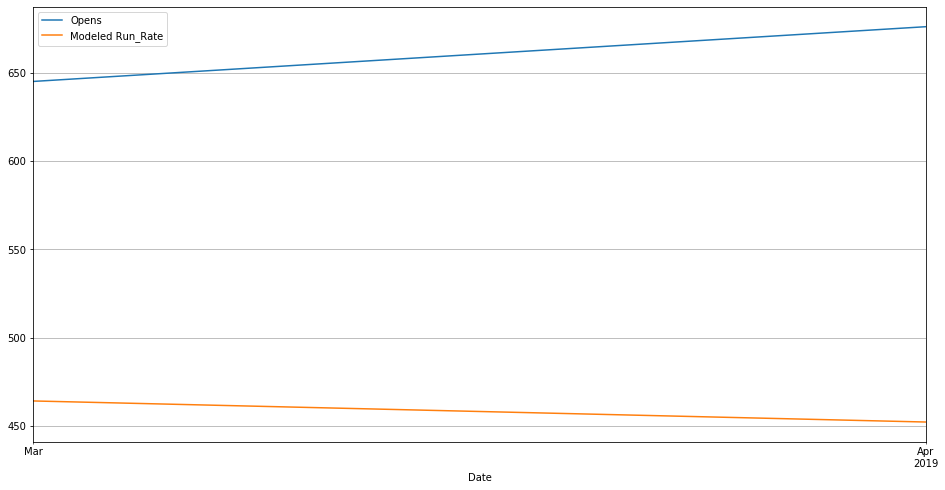

In [21]:
# make a plot of model fit
ax = test.plot(figsize=(16,8), legend=True)
ax1 = predictions.plot(legend=True, grid=True);

# Error Calculations for Model vs Actual
## - Error is 17%

In [22]:
error = rmse(train[1:9], backtest)
error

88.28409178851413

In [23]:
percent = error/train.mean()
percent

0.16934288706236725

In [24]:
# Plot of Both Series
## - Blue line represents actual
## - Shows significant shift from expected run rate (Green Line)
## - Expected run rate of 460; default setting spiked to 600+

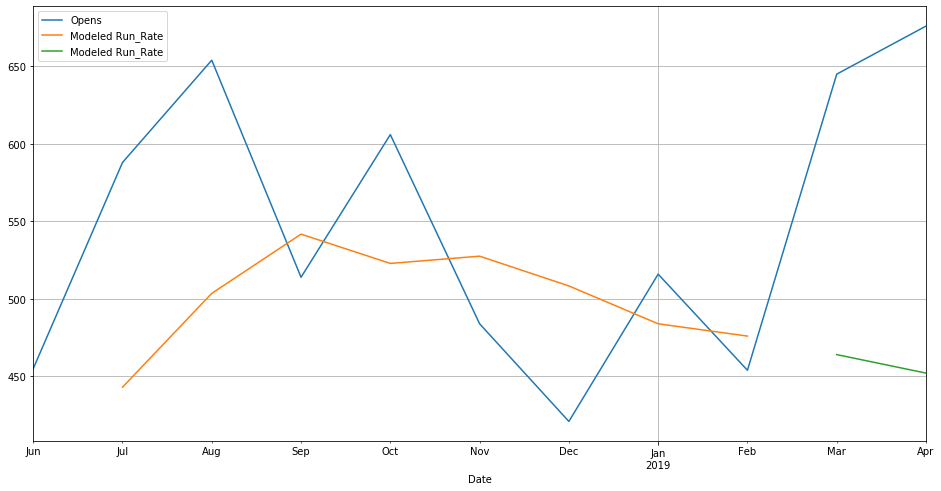

In [25]:
ax = data_red['Opens'].plot(figsize=(16,8), legend=True)
ax1 = backtest.plot(legend=True)
ax2 = predictions.plot(legend=True, grid=True)
ax.autoscale(axis = 'x', tight = True)

# Modeling Joiners

In [26]:
# split enrollements

train = data_red['Joiners'].iloc[0:9]
test = data_red['Joiners'].iloc[9:]

In [27]:
test

Date
2019-03-01    125
2019-04-01    157
Freq: MS, Name: Joiners, dtype: int64

In [28]:
# select 3,0,0 for order

model = ARIMA(train, order=(3,0,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                Joiners   No. Observations:                    9
Model:                     ARMA(3, 0)   Log Likelihood                 -41.753
Method:                       css-mle   S.D. of innovations             20.564
Date:                Wed, 04 Sep 2019   AIC                             93.506
Time:                        15:20:58   BIC                             94.493
Sample:                    06-01-2018   HQIC                            91.378
                         - 02-01-2019                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           170.4805     43.220      3.945      0.011      85.772     255.189
ar.L1.Joiners     1.1179      0.271      4.120      0.009       0.586       1.650
ar.L2.Joiners     0.2169      0.462      0.469      0.659      -0.689       1.123
ar.L3.Joiners    -0.5398      0.273     -1.975      0.105      -1.075      -0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6060           -0.0000j            1.6060           -0.5000
AR.2            1.0039           -0.3818j            1.0740           -0.0578
AR.3            1.0039           +0.3818j            1.0740            0.0578
-----------------------------------------------------------------------------
"""

In [29]:
start = len(train)
end = len(train) + len(test) - 1

predictions = results.predict(start=start, end=end).rename('Enrollment Run Rate')

# Compare Actual Joiners to Model
## - Model shows a good fit of the Joiners data
## - Error rate is 16%

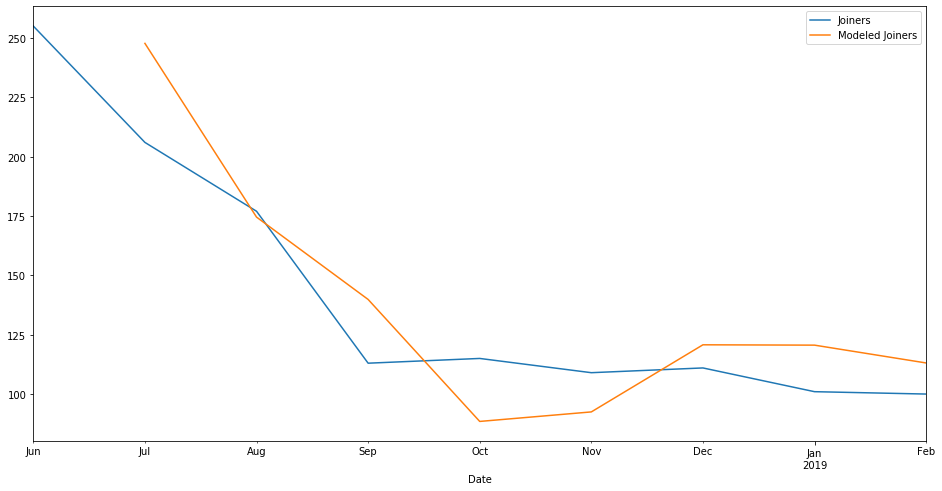

In [30]:
backtest = results.predict(start=1, end=start-1).rename('Modeled Joiners')


# make a plot of model fit
train.plot(figsize=(16,8), legend=True)
backtest.plot(legend=True);

# Compare Actual to Modeled Forecast
## - Expected Run Rate is Much Lower than Actual after the marketing campaign

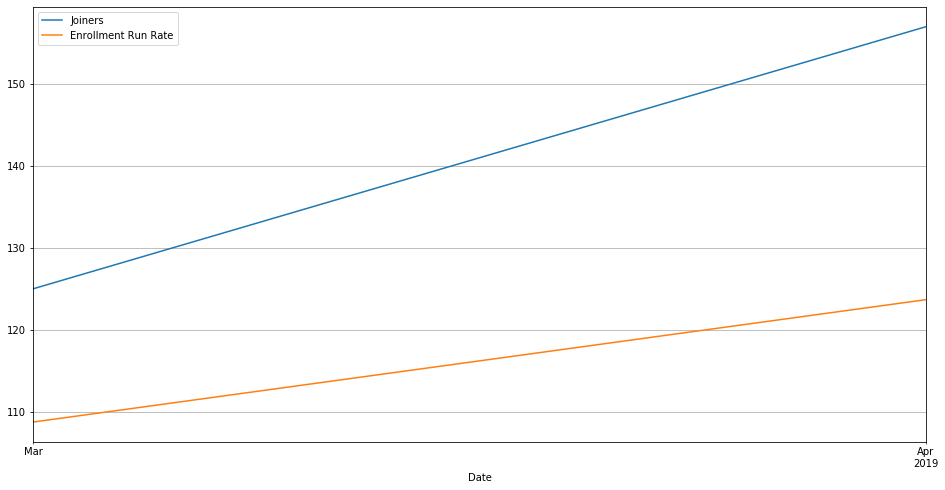

In [31]:
# make a plot of model fit
test.plot(figsize=(16,8), legend=True)
predictions.plot(legend=True, grid=True)

# Error Calculations for Model vs Actual
## - Error is 16%

In [32]:
error = rmse(train[1:9], backtest)
error

22.625040287092713

In [33]:
percent = error/train.mean()
percent

0.15821706494470428

# Overall Plot for Joiners
## - Expected run rate was 125, actual exceeds 150

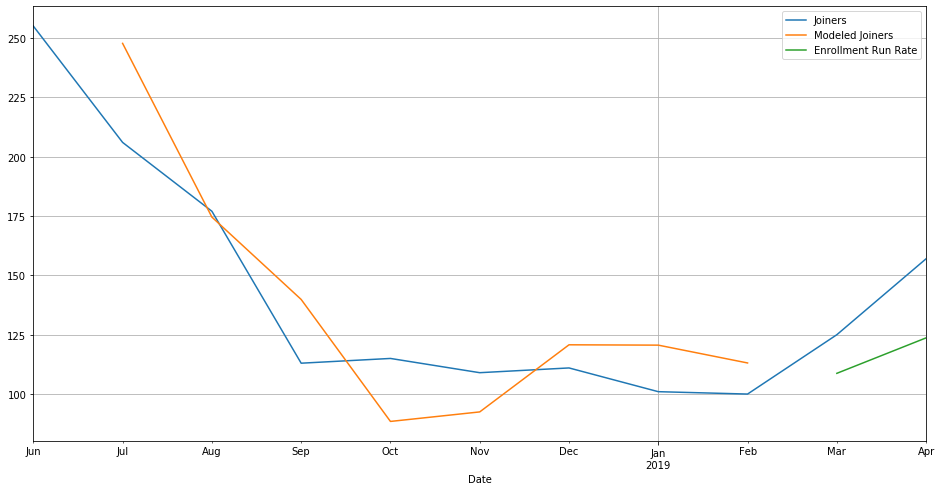

In [34]:
ax = data_red['Joiners'].plot(figsize=(16,8), legend=True)
ax1 = backtest.plot(legend=True)
ax2 = predictions.plot(legend=True, grid=True)
ax.autoscale(axis = 'x', tight = True)